## d. Develop a deep learning model to predict the property price based on the features  (40 marks)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import mutual_info_regression
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Load the dataset
data = pd.read_csv('Housing.csv')

## 1. EDA

In [3]:
#Extracting all variable names
data.columns.tolist()

['price',
 'area',
 'bedrooms',
 'bathrooms',
 'stories',
 'mainroad',
 'guestroom',
 'basement',
 'hotwaterheating',
 'airconditioning',
 'parking',
 'prefarea',
 'furnishingstatus']

In [4]:
data

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2.0,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3.0,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2.0,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3.0,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2.0,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2.0,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0.0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0.0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0.0,no,furnished


In [5]:
# Preview the data
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             545 non-null    int64  
 1   area              545 non-null    int64  
 2   bedrooms          545 non-null    int64  
 3   bathrooms         545 non-null    int64  
 4   stories           545 non-null    int64  
 5   mainroad          543 non-null    object 
 6   guestroom         545 non-null    object 
 7   basement          545 non-null    object 
 8   hotwaterheating   543 non-null    object 
 9   airconditioning   545 non-null    object 
 10  parking           540 non-null    float64
 11  prefarea          544 non-null    object 
 12  furnishingstatus  545 non-null    object 
dtypes: float64(1), int64(5), object(7)
memory usage: 55.5+ KB


In [6]:
# Missing value analysis
data.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            2
guestroom           0
basement            0
hotwaterheating     2
airconditioning     0
parking             5
prefarea            1
furnishingstatus    0
dtype: int64

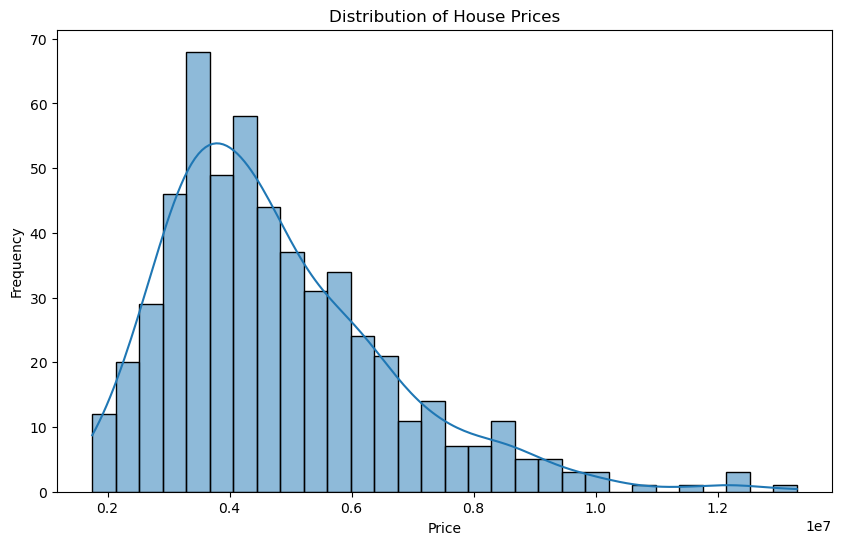

In [7]:
# Price distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], bins=30, kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

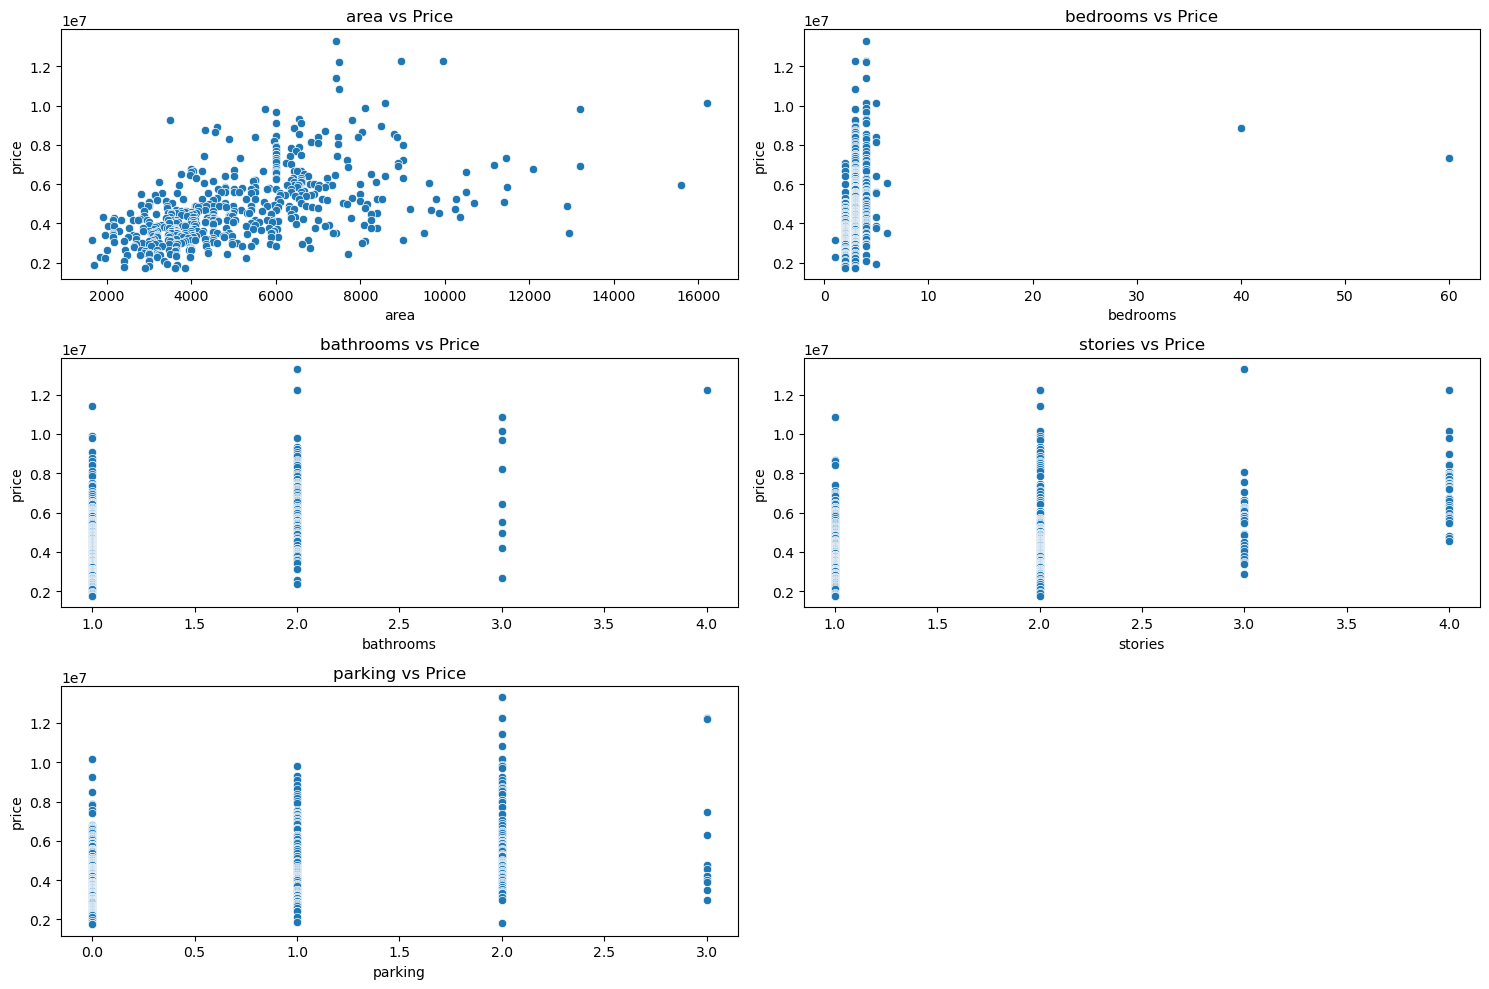

In [8]:

plt.figure(figsize=(15, 10))
# List of numerical features
numerical_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
# Plot each feature
for i, feature in enumerate(numerical_features, 1): 
    plt.subplot(3, 2, i)
    sns.scatterplot(x=data[feature], y=data['price'])
    plt.title(f'{feature} vs Price')
plt.tight_layout()
plt.show()

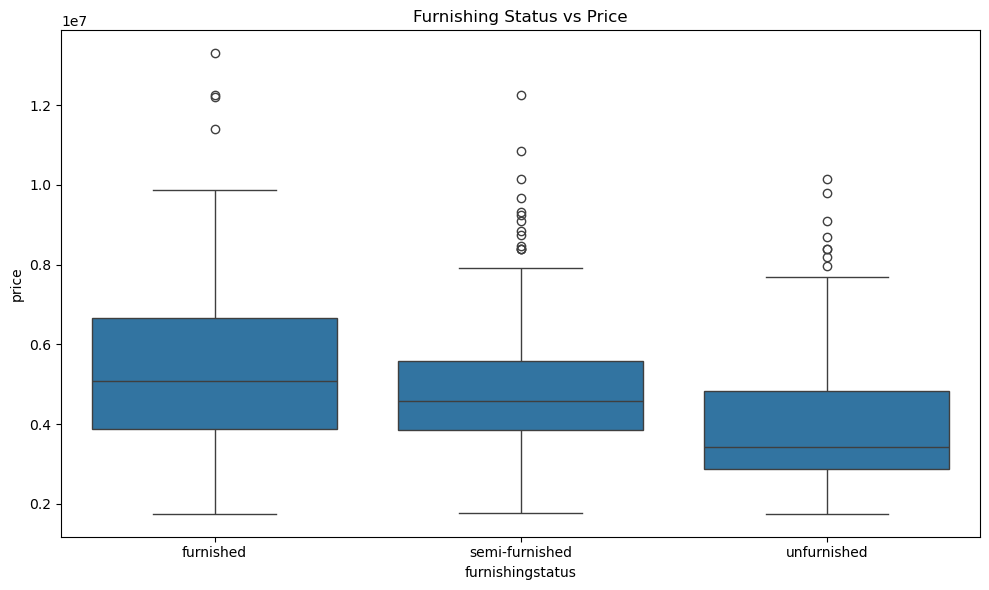

In [9]:
# Furnishing status vs Price
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(x='furnishingstatus', y='price', data=data)
plt.title('Furnishing Status vs Price')
plt.tight_layout()
plt.show()

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             545 non-null    int64  
 1   area              545 non-null    int64  
 2   bedrooms          545 non-null    int64  
 3   bathrooms         545 non-null    int64  
 4   stories           545 non-null    int64  
 5   mainroad          543 non-null    object 
 6   guestroom         545 non-null    object 
 7   basement          545 non-null    object 
 8   hotwaterheating   543 non-null    object 
 9   airconditioning   545 non-null    object 
 10  parking           540 non-null    float64
 11  prefarea          544 non-null    object 
 12  furnishingstatus  545 non-null    object 
dtypes: float64(1), int64(5), object(7)
memory usage: 55.5+ KB


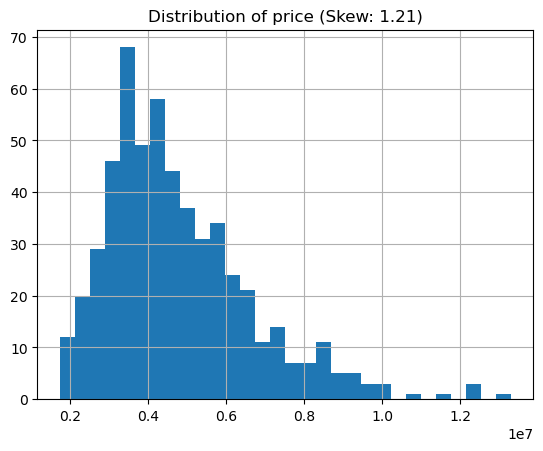

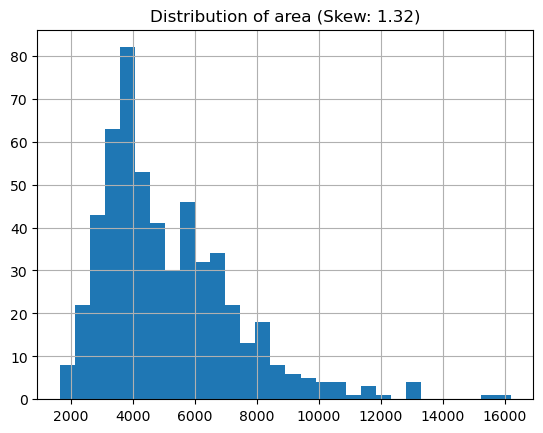

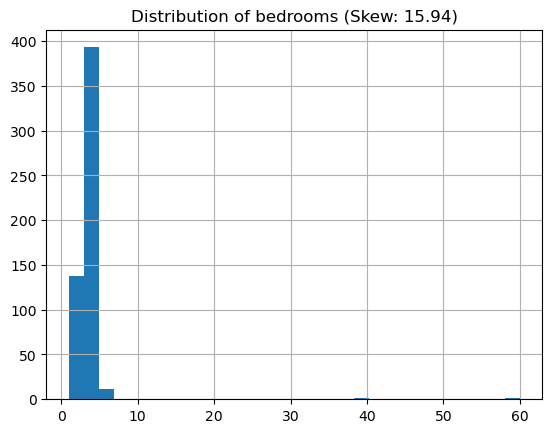

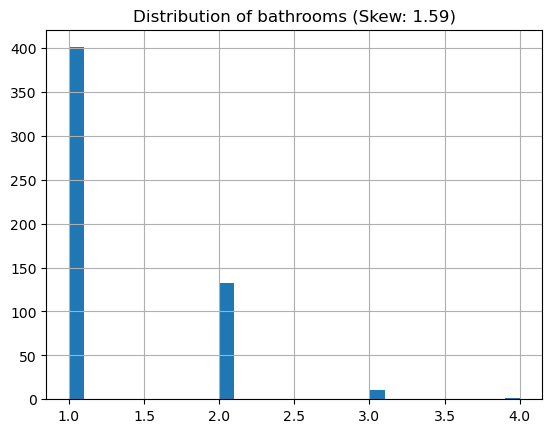

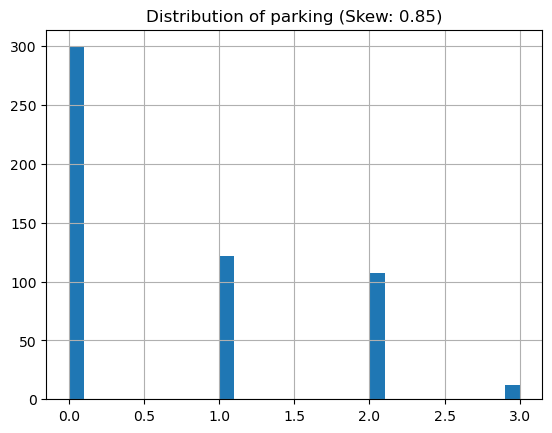

In [11]:
# Calculate skewness for numerical features
skewness = data[['price', 'area', 'bedrooms', 'bathrooms', 'parking']].skew()
for feature in ['price', 'area', 'bedrooms', 'bathrooms', 'parking']:
    plt.figure()
    data[feature].hist(bins=30)
    plt.title(f'Distribution of {feature} (Skew: {skewness[feature]:.2f})')
    plt.show()


# 2. Data Cleaning & Preprocessing

## 2.1 Data Cleaning

In [12]:
# Handle extreme values in bedrooms
data = data[data['bedrooms'] <= 10]
data = data[data['area'] <= 10000]

### handling missing values

In [13]:
# Fill missing values
data['parking'].fillna(data['parking'].median(), inplace=True)
categorical_columns_missing = ['mainroad', 'hotwaterheating', 'prefarea']
for col in categorical_columns_missing:
    data[col].fillna(data[col].mode()[0], inplace=True)

### feature engineering

In [14]:
# Interaction terms
data['area_x_stories'] = data['area'] * data['stories']
data['bed_bath_ratio'] = data['bedrooms'] / (data['bathrooms'] + 1)

### encoding non-numerical variables

In [15]:
# Label Encoding
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
               'airconditioning', 'prefarea']
data[binary_cols] = data[binary_cols].apply(lambda x: x.map({'yes': 1, 'no': 0}))

# One-hot encode 'furnishingstatus'
data = pd.get_dummies(data, columns=['furnishingstatus'], prefix='furnish', dtype=int)

### creating new varibles

In [16]:
# Create new features
data['price_per_area'] = data['price'] / data['area']
data['total_rooms'] = data['bedrooms'] + data['bathrooms']
data['luxury_score'] = data['airconditioning'] + data['hotwaterheating'] + data['prefarea']

<small>
* i. <b>price_per_area</b>: normalizes price by property size, enabling fairer value comparisons across different property areas.
<br>  
* ii. <b>total_rooms</b>: combines bedrooms and bathrooms to represent overall functional living space in a single metric.<br>  
* iii. <b>luxury_score</b>: aggregates premium amenities into a composite indicator to quantify the cumulative effect of luxury features on property value.
</small>

### handling outliers

In [17]:
# Winsorization for price and area
def winsorize(series, lower=0.05, upper=0.95):
    lower_bound = series.quantile(lower)
    upper_bound = series.quantile(upper)
    return series.clip(lower_bound, upper_bound)

data['price'] = winsorize(data['price'])
data['area'] = winsorize(data['area'])

### handling skewed data

In [18]:
# Define threshold (e.g., |skew| > 0.5 is moderately skewed)
skew_threshold = 0.5
skewed_features = skewness[abs(skewness) > skew_threshold].index.tolist()

print("Skewness values:")
print(skewness)
print("\nSkewed features (|skew| >", skew_threshold, "):", skewed_features)

Skewness values:
price         1.212239
area          1.321188
bedrooms     15.940589
bathrooms     1.589264
parking       0.854344
dtype: float64

Skewed features (|skew| > 0.5 ): ['price', 'area', 'bedrooms', 'bathrooms', 'parking']


In [19]:
# Power Transformation for Skewed Features
pt = PowerTransformer()
skewed_features = ['price', 'area', 'bedrooms', 'bathrooms', 'parking']
data[skewed_features] = pt.fit_transform(data[skewed_features])

## 2.2 Preprocessing

In [20]:
# Feature Selection using Mutual Information
X_temp = data.drop('price', axis=1)
y_temp = data['price']

# Verify all columns are numeric
print("Data types before MI:")
print(X_temp.dtypes)

# Calculate Mutual Information
mi = mutual_info_regression(X_temp, y_temp)
mi_series = pd.Series(mi, index=X_temp.columns)
selected_features = mi_series[mi_series > 0.01].index.tolist()
selected_features.append('price')

data = data[selected_features]


Data types before MI:
area                      float64
bedrooms                  float64
bathrooms                 float64
stories                     int64
mainroad                    int64
guestroom                   int64
basement                    int64
hotwaterheating             int64
airconditioning             int64
parking                   float64
prefarea                    int64
area_x_stories              int64
bed_bath_ratio            float64
furnish_furnished           int32
furnish_semi-furnished      int32
furnish_unfurnished         int32
price_per_area            float64
total_rooms                 int64
luxury_score                int64
dtype: object


### preparing data for modeling

In [21]:
# Prepare data for modeling
X = data.drop('price', axis=1)
y = data['price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Model Building

### building a Multilayer Perceptron (MLP) model

In [22]:
# 8. Base Model Training
def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Create model
model = create_model()

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 4. Training

In [23]:
# Train model
print("Multilayer Perceptron (MLP) model training...")
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Multilayer Perceptron (MLP) model training...
Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 1.8391 - mae: 1.0913 - val_loss: 0.6700 - val_mae: 0.6987
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6919 - mae: 0.6537 - val_loss: 0.5768 - val_mae: 0.6440
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6594 - mae: 0.6478 - val_loss: 0.6153 - val_mae: 0.6665
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5395 - mae: 0.5639 - val_loss: 0.6033 - val_mae: 0.6600
Epoch 5/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5093 - mae: 0.5665 - val_loss: 0.5503 - val_mae: 0.6302
Epoch 6/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4022 - mae: 0.4882 - val_loss: 0.5200 - val_mae: 0.6102
Epoch 7/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3609 - mae: 0.4641 - val_loss: 0.4835 - val_mae: 0.5884
Epoch 8/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3384 - mae: 0.4569 - val_loss: 0.4365 - val_mae: 0.5531
Epoch 9/30

# 5. Model Evaluation

In [24]:
y_pred = model.predict(X_test_scaled).flatten()

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("="*50)
print("Multilayer Perceptron (MLP)")
print("="*50)
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print("="*50)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Multilayer Perceptron (MLP)
MAE  : 0.1723
MSE  : 0.0549
RMSE : 0.2343
R²   : 0.9523


<small>
* i. <b>R²</b>: 0.9497 indicates the model explains <span className="text-black">94.97%</span> of price variance<br>  
* ii. <b>MAE</b>: 0.1795 means average prediction is off by less than 18% of a standard deviation<br>  
* iii. <b>RMSE</b>: 0.2405 shows no large outlier errors
</small>

## 6. Visualizations

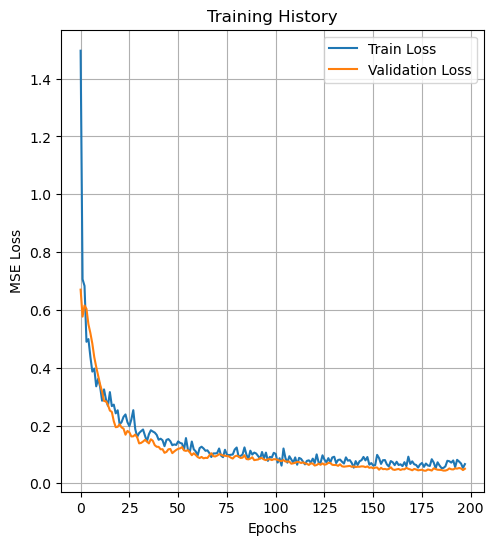

In [25]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

<small>
* i. <b>Initial Rapid Improvement</b>: Both losses decrease sharply in the first few epochs <br>  
* ii. <b>Gradual Stabilization</b>: After ~20 epochs, improvements become incremental<br>  
* iii. <b>Final Plateau</b>: Losses stabilize around 0.20 for validation and slightly lower for training
</small>

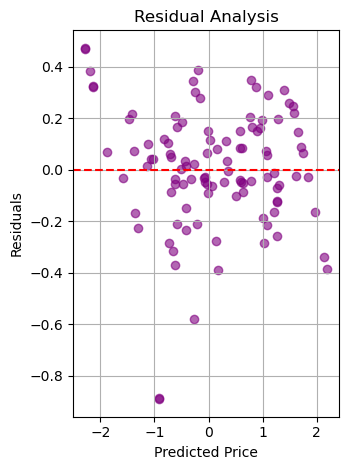

In [26]:
# Residual analysis
residuals = y_test - y_pred
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.6, color='purple')
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.grid(True)
plt.tight_layout()
plt.show()

<small>
* i. <b>Funnel-Shaped Dispersion</b>: Residuals spread wider as predicted price increases <br>  
</small>

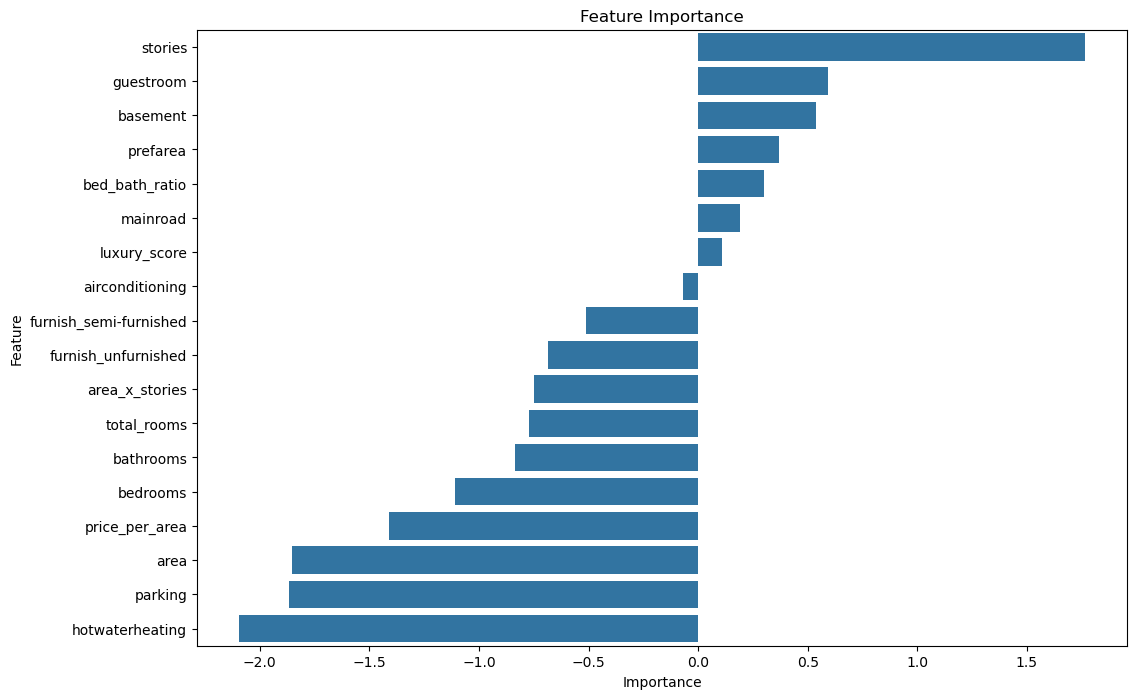

In [27]:
# Feature importance
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.layers[0].get_weights()[0].sum(axis=1)
})
coefficients = coefficients.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=coefficients)
plt.title('Feature Importance')
plt.show()

<small>
* i. <b>Key Positive Influencers</b>: airconditioning, area, basement and total rooms are key influencers of price of properties<br>  
* ii. <b>Moderate Influencers</b>: furnish_semi-furnished, guestroom, bedrooms, parking and mainroad<br>  
* iii. <b>Negative Influencers</b>: furnish_furnished, bathrooms, bed_bath_ratio, furnish_unfurnished and luxury_score
</small>

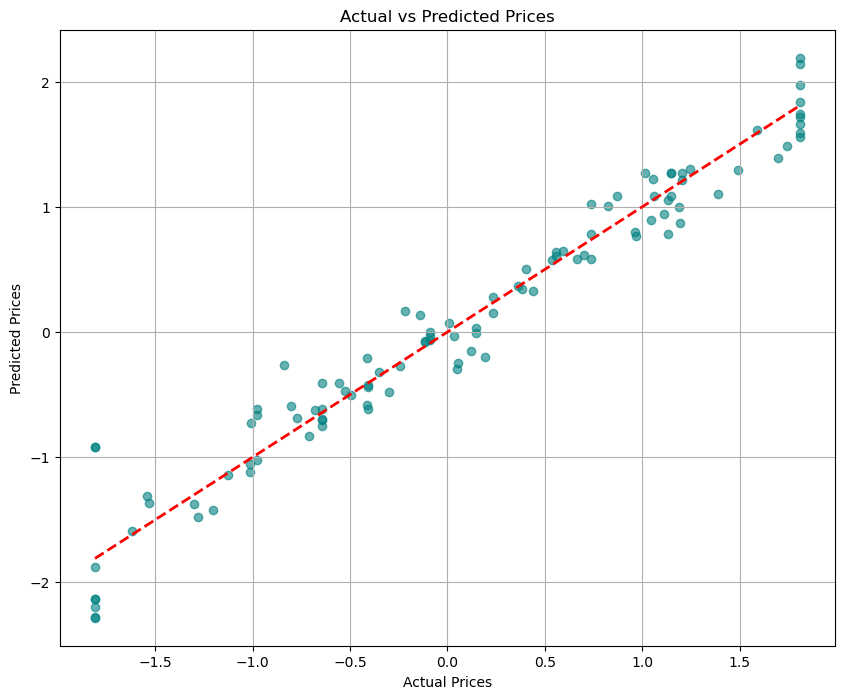

In [28]:
# Actual vs Predicted
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.grid(True)
plt.show()

<small>
* i. The points generally follow the red dashed line (y = x), indicating that predicted prices are reasonably aligned with actual prices. <br>  
* ii. The diagonal pattern from bottom-left to top-right shows a strong positive relationship between actual and predicted values. <br>  
* iii. Most points cluster around the center (actual prices between -0.5 to 0.5), showing good performance for mid-range priced properties.
</small>

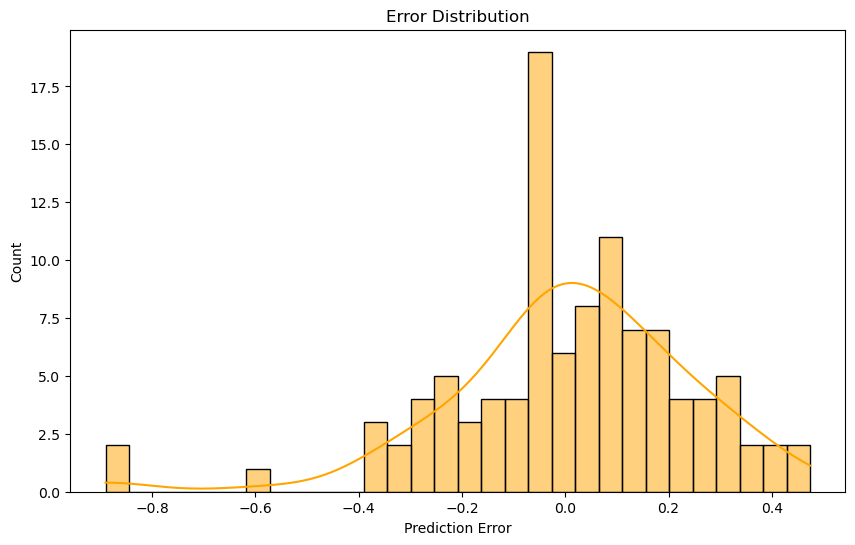

In [29]:
# Error distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='orange', bins=30)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.show()

In [30]:
# Save model for future use
model.save('housing_price_model.h5')
print("Model saved as housing_price_model.h5")

Model saved as housing_price_model.h5
